In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import laplace_asymmetric

In [2]:
''' Data Generation '''
################################'Generate X and Y'##############################
################################ Xt ~ N(0,1)
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
def generate_data(T, alpha_y, beta_y, gamma, theta, sigma_y, mu, seed=None):
    np.random.seed(seed)
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y'])
    x = np.random.normal(0, 1, T)
    y1 = np.random.normal(mu, sigma_y)
    epsilon_y = sigma_y*np.random.randn(T)
    df.iloc[0,:] = [x[0], y1, epsilon_y[0]]
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = x[i+1] 
        # Xt ~ N(0,1)
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
        # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_y[i+1]
    
    return df

In [3]:
df = generate_data(1000, 0.2, 0.5, 0.3, 0.9, 1, 0, seed=42)
print(df)

            x         y epsilon_y
0    0.496714  1.399355  0.924634
1   -0.138264  1.749999   0.05963
2    0.647689  0.676037 -0.646937
3     1.52303  1.110908  0.698223
4   -0.234153  1.707094  0.393485
..        ...       ...       ...
995   -0.2811  2.353144 -0.026521
996  1.797687  1.010134 -0.881875
997  0.640843 -0.059434 -0.163067
998 -0.571179 -0.892734 -0.744903
999  0.572583 -1.420183 -0.675178

[1000 rows x 3 columns]


In [4]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration

        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon_y, 1)
        epsilon_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")


In [18]:
M=1000
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.25447061320741066]
OLS beta_hat:  [0.5900422629395783]
OLS gamma_hat:  [0.2512666211612553]
OLS theta_hat:  [0.9999999999999994]
GLS alpha_hat:  [0.27438451057842206]
GLS beta_hat:  [0.5585761912495335]
GLS gamma_hat:  [0.25306784029104556]
GLS theta_hat:  [1.000000000000221]
OLS_bias_param_0 = -0.0545
OLS_bias_param_1 = -0.0900
OLS_bias_param_2 = 0.0487
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.0766
GLS_bias_param_0 = -0.0744
GLS_bias_param_1 = -0.0586
GLS_bias_param_2 = 0.0469
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.0727


In [ ]:

# Estimate rho, sigma2, and C
rho = np.corrcoef(z[:-1], z[1:])[0, 1]
sigma2 = np.var(z)
C = np.cov(z[:-1], z[1:])[0, 1]

# Construct the variance-covariance matrix Sigma
n = len(z)
Sigma = np.zeros((n, n))
Sigma[np.diag_indices(n)] = sigma2
for i in range(n):
    for j in range(n):
        if i != j:
            Sigma[i, j] = C * rho ** np.abs(i - j)

# Print the constructed variance-covariance matrix
print("Variance-Covariance Matrix (Sigma):")
print(Sigma)

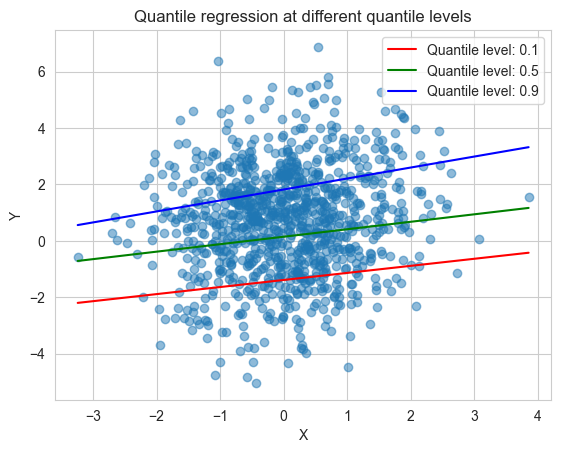

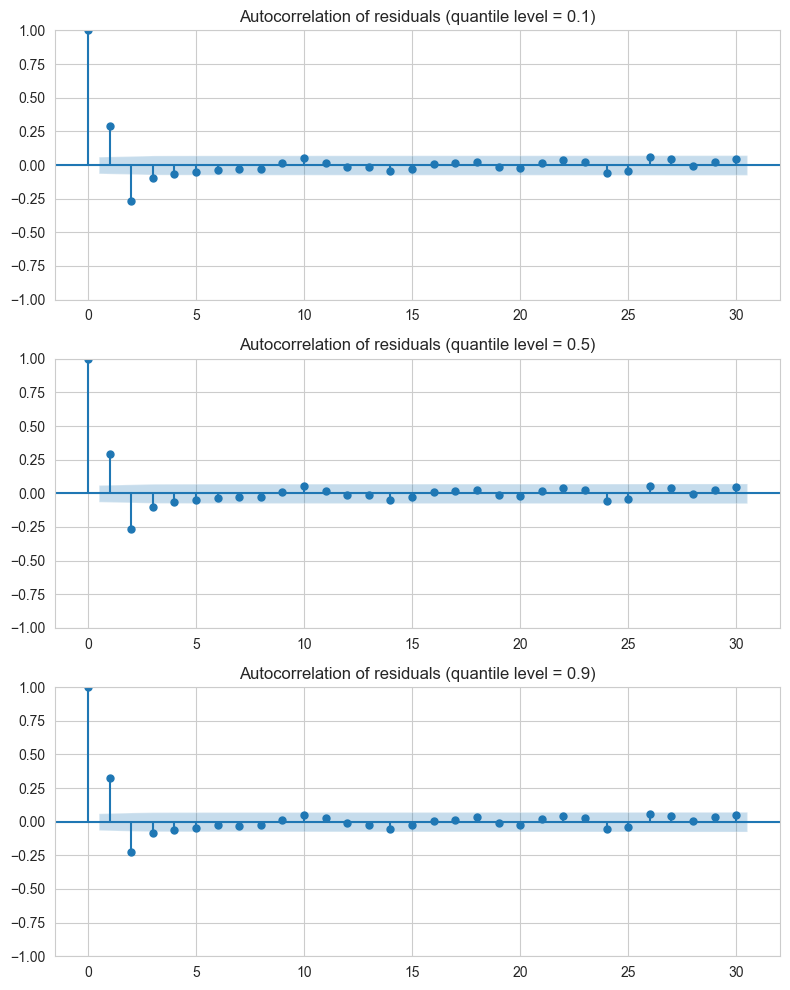

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.3451
 Model:                       QuantReg   Bandwidth:                      0.4867
 Method:                 Least Squares   Sparsity:                        7.633
 Date:                Wed, 14 Jun 2023   No. Observations:                 1000
 Time:                        17:21:06   Df Residuals:                      997
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -1.3888      0.078    -17.845      0.000      -1.542      -1.236
 x1             0.7595      0.040     18.828      0.000       0.680       0.839
 x2             0.2507      0.077      3.277      0.001       0.101   

In [54]:
################################ Quantile linear regression with package ################################
def fit_quantile(df):
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 100)

    # Plot the regression lines
    ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

fit_quantile(df)

In [14]:
def Laplace_estimation(df, p, M):

    def log_l_Asym_Lap(params, X, y):
        params = params
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1-p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2*p) / p * (1-p)
        ll -= np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(((y - X @ params - θ * z)**2)/(np.sqrt(τ_2)*np.sqrt(z))**2))
        return -ll

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
    
        params0 = np.array([0.2, 0.5, 0.3], dtype=float)  # Reshape to 1D array
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Nelder-Mead')  # minimize the negative log-likelihood
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1

        actuals = np.array([0.2, 0.5, 0.3])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix

result_matrix = Laplace_estimation(df, 0.5, 100)


Beta Matrix:
[[0.2        0.5        0.315     ]
 [0.2        0.5        0.315     ]
 [0.21       0.5        0.3       ]
 [0.21       0.5125     0.285     ]
 [0.20333333 0.51944444 0.31166667]
 [0.21       0.5        0.3       ]
 [0.19722222 0.51388889 0.31583333]
 [0.20277778 0.50694444 0.30916667]
 [0.19131944 0.4984375  0.3003125 ]
 [0.20666667 0.51666667 0.31      ]
 [0.2        0.5        0.315     ]
 [0.21111111 0.46111111 0.29833333]
 [0.21       0.5        0.3       ]
 [0.19333333 0.48611111 0.31666667]
 [0.20166667 0.50416667 0.3075    ]
 [0.2        0.525      0.3       ]
 [0.20166667 0.50416667 0.3075    ]
 [0.2        0.5        0.3       ]
 [0.20185185 0.5462963  0.28333333]
 [0.20279835 0.5468107  0.28148148]
 [0.2        0.5        0.3       ]
 [0.20638889 0.51597222 0.29125   ]
 [0.2        0.5        0.315     ]
 [0.21       0.5        0.3       ]
 [0.21       0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.19080247 0.

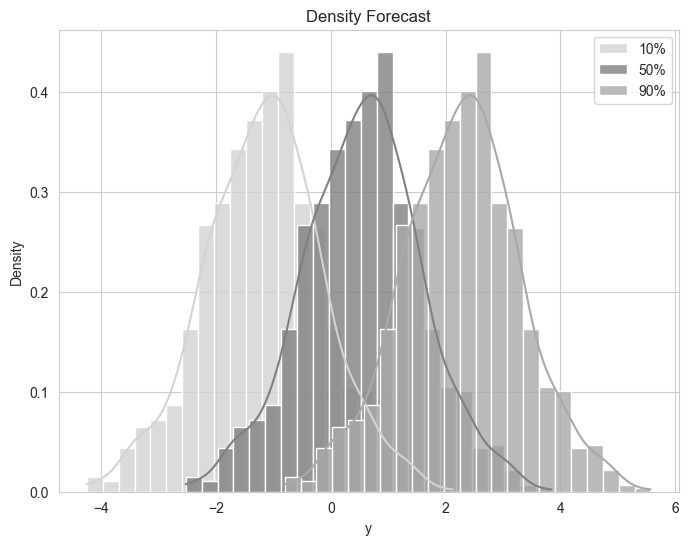

In [44]:
from scipy.stats import norm
import seaborn as sns

sns.set_style('whitegrid')
T = len(y)
alpha_l, beta_l, gamma_l = [0.20284946, 0.5063545,  0.30277903] # Extract parameters from Laplace estimation
sigma_hat = 1
theta_hat = 0.9
# Set quantile levels
quantiles = [0.1, 0.5, 0.9]
num_quantiles = len(quantiles)

# Generate density forecasts for each quantile level
density_forecasts = np.zeros((T, num_quantiles))
for i, q in enumerate(quantiles):
    for t in range(T):
        mu = alpha_l + beta_l * y[t] + gamma_l * x[t]
        density_forecasts[t, i] = mu + norm.ppf(q) * sigma_hat * np.sqrt(1 + theta_hat**2)

# Step 3: Plot density forecast using histogram with different color intensity
fig, ax = plt.subplots(figsize=(8,6))
colors = ["lightgray", "gray", "darkgray"]
for i, q in enumerate(quantiles):
    sns.histplot(density_forecasts[:, i], kde=True, stat='density', ax=ax, color=colors[i], alpha=0.8, label='{}%'.format(int(q * 100)))
ax.set_xlabel('y')
ax.set_ylabel('Density')
ax.set_title('Density Forecast')
ax.legend()
plt.show()


In [229]:
''' Nelder-Mead 10-good 100-good 1000no

'''


' Nelder-Mead 10-good 100-good 1000no\n\n'

In [231]:
# z_t^{-1} from a IG (Inverse Gaussian) ~ IG(3μ,λ) - mode μ[ np.sqrt(1 + 9μ**2/4λ**2) - 3μ/2λ] 
# beta ~ MVN(μ, Σ)                                    - mode m
# σ from Inverted Gamma ~ IΓ(α,β)                  - mode β/α +1


''' EM Algorithm 
def EM_Algorithm(df, M):

1. z_t^{-1} from a IG (Inverse Gaussian) ~ IG(3μ,λ) - mode μ[ np.sqrt(1 + 9μ**2/4λ**2) - 3μ/2λ] 
    initialize μ and λ based on the data (y) - mean
    
    for i in M = number of iterations
    # E step: compute the mode in closed form 
        mode = mu * (np.sqrt(1 + 9 * mu**2 / (4 * lambd**2)) - 3 * mu / (2 * lambd))
    
    # M step: update the parameters
        ?

    return mu, lambd
    ?how does it relate to z?
2. beta ~ MVN(μ, Σ) - mode m                                  
    initialize μ, Σ based on assumptions
    
    for i in M = number of iterations
    # E step: compute the mode in closed form 
        m
    
    # M step: update the parameters
        ?

    return m
    ?how does it relate to beta?

3. σ from Inverted Gamma ~ IΓ(α,β) - mode β/α +1
    initialize α,β based on assumptions
    
    for i in M = number of iterations
    # E step: compute the mode in closed form 
        β/α +1
    
    # M step: update the parameters
        ?

    return α,β
    ?how does it relate to sigma?

feed into liklihood 
'''

' EM Algorithm \ndef EM_Algorithm(df, M):\n\n1. z_t^{-1} from a IG (Inverse Gaussian) ~ IG(3μ,λ) - mode μ[ np.sqrt(1 + 9μ**2/4λ**2) - 3μ/2λ] \n    initialize μ and λ based on the data (y) - mean\n    \n    for i in M = number of iterations\n    # E step: compute the mode in closed form \n        mode = mu * (np.sqrt(1 + 9 * mu**2 / (4 * lambd**2)) - 3 * mu / (2 * lambd))\n    \n    # M step: update the parameters\n        ?\n\n    return mu, lambd\n    ?how does it relate to z?\n2. beta ~ MVN(μ, Σ) - mode m                                  \n    initialize μ, Σ based on assumptions\n    \n    for i in M = number of iterations\n    # E step: compute the mode in closed form \n        m\n    \n    # M step: update the parameters\n        ?\n\n    return m\n    ?how does it relate to beta?\n\n3. σ from Inverted Gamma ~ IΓ(α,β) - mode β/α +1\n    initialize α,β based on assumptions\n    \n    for i in M = number of iterations\n    # E step: compute the mode in closed form \n        β/α +1\n

In [ ]:
''' 
    Σ_ = np.diag(Σ)
    Σ_ = Σ_.reshape((-1, 1))
    r = θ / (σ_ * τ_2)
    r = r.reshape((-1, 1))
    w = (X.T @ U @ y)
    w = w.reshape((-1, 1))

    print(w.shape)
    #m[i+1] = Σ @ (X.T @ U @ y) - ((r_matr) @ (X.T @ l))

    print(Σ.shape)
    print(Σ_.shape)
    print((Σ_ * w).shape)
    print((X.T @ l).shape)
    print(r.shape)

    m[i+1] = Σ_ * w - (X.T @ l) * r
'''

In [29]:
''' prove 13/09'''
df = df.astype('float64')
x = df['x'].values
y = df['y'].values
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_ha = np.linalg.inv(X.T @ X) @ X.T @ y
z = y - X @ beta_ha
print(beta_ha)
print(np.sum(z))


# Calculating rho (correlation between error i and error j)
rho = np.corrcoef(z[:-1], z[1:])[0, 1]
sigma2 = np.var(z)
C = np.cov(z[:-1], z[1:])[0, 1]

print("rho:", rho)
print("sigma2:", sigma2)
print(C)

[0.16649059 0.74366533 0.29377513]
-3.694822225952521e-13
rho: 0.3033380361098973
sigma2: 1.558343584782535
0.473291391800634


In [30]:

# Estimate rho, sigma2, and C
rho = np.corrcoef(z[:-1], z[1:])[0, 1]
sigma2 = np.var(z)
C = np.cov(z[:-1], z[1:])[0, 1]

# Construct the variance-covariance matrix Sigma
n = len(z)
Sigma = np.zeros((n, n))
Sigma[np.diag_indices(n)] = sigma2
for i in range(n):
    for j in range(n):
        if i != j:
            Sigma[i, j] = C * rho ** np.abs(i - j)

# Print the constructed variance-covariance matrix
print("Variance-Covariance Matrix (Sigma):")
print(Sigma)


Variance-Covariance Matrix (Sigma):
[[1.55834358 0.14356728 0.04354942 ... 0.         0.         0.        ]
 [0.14356728 1.55834358 0.14356728 ... 0.         0.         0.        ]
 [0.04354942 0.14356728 1.55834358 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.55834358 0.14356728 0.04354942]
 [0.         0.         0.         ... 0.14356728 1.55834358 0.14356728]
 [0.         0.         0.         ... 0.04354942 0.14356728 1.55834358]]


In [33]:
from scipy.linalg import toeplitz
# Estimate rho and sigma2
rho = np.corrcoef(z[:-1], z[1:])[0, 1]
sigma2 = np.var(z)

# Construct the autocovariance vector
autocov = np.full(len(z), sigma2 * rho)
autocov[0] = sigma2

# Construct the variance-covariance matrix Sigma
Sigma = toeplitz(autocov)

# Print the constructed variance-covariance matrix
print("Variance-Covariance Matrix (Sigma):")
print(Sigma)


Variance-Covariance Matrix (Sigma):
[[1.55834358 0.47270488 0.47270488 ... 0.47270488 0.47270488 0.47270488]
 [0.47270488 1.55834358 0.47270488 ... 0.47270488 0.47270488 0.47270488]
 [0.47270488 0.47270488 1.55834358 ... 0.47270488 0.47270488 0.47270488]
 ...
 [0.47270488 0.47270488 0.47270488 ... 1.55834358 0.47270488 0.47270488]
 [0.47270488 0.47270488 0.47270488 ... 0.47270488 1.55834358 0.47270488]
 [0.47270488 0.47270488 0.47270488 ... 0.47270488 0.47270488 1.55834358]]


In [58]:
''' 13/06 making EM function'''
def EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior):
    y = df['y'].values
    x = df['x'].values
    y = np.array(y)
    x = np.array(x)
    T = len(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)
        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        #print('gamma:', gamma)
        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_
        #μ
        abso = np.zeros((len(x), 1))
        for j in range(T):  
            abso[j] = np.abs(y[j] - X[j] @ β)
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(abso))
        #print('μ:', μ)
        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i+1] = 1 / mode_z_inverse
        #z[i+1] = mode_z_inverse
        #print('z[i+1]:', z[i+1])
        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

        actuals = np.array([0.2, 0.5, 0.3])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(β)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE

        print("\nRMSE:")
        print(rmse)

        print("\nMean of RMSE:")
        print(np.mean(rmse))

    return β_values



In [59]:
n = 1000
p = 0.5
df = df.astype('float64')
M = 50 # Number of iterations
sigma_ini = 1.55
β = np.array([0.16649059, 0.74366533, 0.29377513]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [1534479.85317034 6245699.57425012  682152.30882378]

RMSE:
3734020.0732567594

Mean of RMSE:
3734020.0732567594
Iteration 2: [3.96480887e-08 9.54444061e-08 7.03785341e-08]

RMSE:
0.3559025442539618

Mean of RMSE:
0.3559025442539618
Iteration 3: [1928685.62245589 4643147.51430938 3423160.19638085]

RMSE:
3511726.362567901

Mean of RMSE:
3511726.362567901
Iteration 4: [9.30880560e-08 2.24162270e-07 1.65159366e-07]

RMSE:
0.3559024577950279

Mean of RMSE:
0.3559024577950279
Iteration 5: [ 687064.19978659 1662972.28453577 1228382.47776829]

RMSE:
1257836.1260299925

Mean of RMSE:
1257836.1260299925
Iteration 6: [8.33480723e-07 2.02440765e-06 1.49790049e-06]

RMSE:
0.35590124854505895

Mean of RMSE:
0.35590124854505895
Iteration 7: [ 73644.25565902 182076.0292012  129407.82558185]

RMSE:
135795.53916504214

Mean of RMSE:
135795.53916504214
Iteration 8: [7.09125334e-05 1.72726743e-04 1.26208684e-04]

RMSE:
0.3557871486738119

Mean of RMSE:
0.3557871486738119
Iteration 9: [ 879.

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.53447985e+06, 6.24569957e+06, 6.82152309e+05],
       [3.96480887e-08, 9.54444061e-08, 7.03785341e-08],
       [1.92868562e+06, 4.64314751e+06, 3.42316020e+06],
       [9.30880560e-08, 2.24162270e-07, 1.65159366e-07],
       [6.87064200e+05, 1.66297228e+06, 1.22838248e+06],
       [8.33480723e-07, 2.02440765e-06, 1.49790049e-06],
       [7.36442557e+04, 1.82076029e+05, 1.29407826e+05],
       [7.09125334e-05, 1.72726743e-04, 1.26208684e-04],
       [8.79157226e+02, 2.14140952e+03, 1.56686519e+03],
       [1.67488110e-01, 4.08161838e-01, 2.98226982e-01],
       [3.47926725e-01, 8.89034137e-01, 6.78277505e-01],
       [2.42397396e-01, 6.03023940e-01, 4.49426120e-01],
       [2.42274736e-01, 6.02761135e-01, 4.49216542e-01],
       [2.41421091e-01, 6.01680390e-01, 4.53532595e-01],
       [2.40323487e-01, 6.01294933e-01, 4.56222107e-01],
       [2.40345728e-01, 6.01197413e-01, 4.54983994e-01],
       [2.41661907e-01, 6.02081

In [39]:
''' 13/06 making EM + FGLS instead of OLS'''
def EM_Algorithm2(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior):
    y = df['y'].values
    x = df['x'].values
    y = np.array(y)
    x = np.array(x)
    T = len(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)
    z = z.reshape((-1, 1))

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)
        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        #print('gamma:', gamma)
        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_

        e = y - X @ β
# Calculating rho (correlation between error i and error j)
        rho = np.corrcoef(e[:-1], e[1:])[0, 1]
        print(rho)
        sigma2 = np.var(e)
        #C = np.cov(e[:-1], e[1:])[0, 1]

        #n = len(e)
        #Sigma = np.zeros((n, n))
        #Sigma[np.diag_indices(n)] = sigma2
        #for f in range(n):
            #for d in range(n):
                #if f != d:
                    #Sigma[f, d] = C * rho ** np.abs(f - d)
        #print(Sigma)
        autocov = np.full(len(e), sigma2 * rho)
        autocov[0] = sigma2

# Construct the variance-covariance matrix Sigma
        Sigma = toeplitz(autocov)

        print(Sigma)
        #μ
    
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(np.abs(Sigma * y - X @ β * Sigma)))
        print('μ:', μ)
        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i] = 1 / mode_z_inverse
        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

        actuals = np.array([0.2, 0.5, 0.3])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(β)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE

        print("\nRMSE:")
        print(rmse)
        
    return β_values



In [40]:
n = 1000
p = 0.5
df = df.astype('float64')
M = 2 # Number of iterations
sigma_ini = 1.55
β = np.array([0.16649059, 0.74366533, 0.29377513]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm2(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


nan
[[1.38323327e+14            nan            nan ...            nan
             nan            nan]
 [           nan 1.38323327e+14            nan ...            nan
             nan            nan]
 [           nan            nan 1.38323327e+14 ...            nan
             nan            nan]
 ...
 [           nan            nan            nan ... 1.38323327e+14
             nan            nan]
 [           nan            nan            nan ...            nan
  1.38323327e+14            nan]
 [           nan            nan            nan ...            nan
             nan 1.38323327e+14]]
μ: nan
Iteration 1: [1534479.85317034 6245699.57425012  682152.30882378]

RMSE:
3734020.0732567594
nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
μ: nan
Iteration 2: [nan nan nan]

RMSE:
nan


array([[      0.        ,       0.        ,       0.        ],
       [1534479.85317034, 6245699.57425012,  682152.30882378],
       [             nan,              nan,              nan]])